## Regional Paper Research figures

In [1]:
import sys;sys.path.append('../adcirc_swan')
import adcirc as adc
import regional as reg
import utils as ut
import pathlib as pl
from importlib import reload
from libs import *
from scipy.io import loadmat 
import geopandas as gpd
import sys;sys.path.append('../../xbeach/xbeach')
#import xbeach
import requests
import json

#### Paths

In [2]:
root = pl.Path(r'D:\FHRL_work\Projects\eeslr\modelling\Joaquin3')
path = pl.Path(r'D:\FHRL_work\Projects\eeslr\misc_data')

# model start/end time and frequency
start = '20150918 00:00:00'
freq = '30min'

#### Find Observation Wave Buoy

In [3]:
lat1,lat2 = 36.5,37
lon1,lon2 = -76,-75
year = 2015
path = pl.Path(r'D:\FHRL_work\Projects\eeslr\misc_data')
data = reg.find_wave_buoy(year,lat1,lat2,lon1,lon2,path)

#### Plot Wave Buoy vs. Model

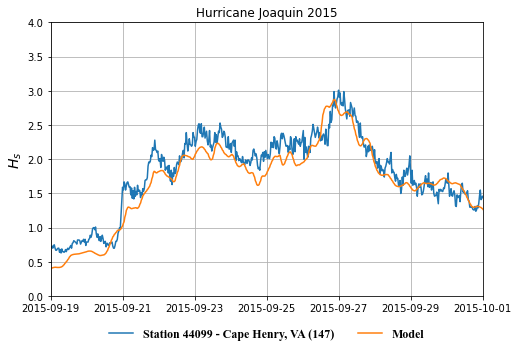

In [4]:
# initialize figure
fig = plt.figure(figsize=(6,4))
ax = plt.axes([0,0,1,.95])
plt.rcParams["font.family"] = "Times New Roman"

# plot data
nc_file = nc4.Dataset(root  / 'implicit015' / 'swan_HS.63.nc')
for i in range(len(data['DateTime'])):
    ax.plot(data['DateTime'][i],data['WVHT'][i],label=data['Name'][i])
    node = ut.find_node_ak(nc_file,data['Loc'][i][0],data['Loc'][i][1])
    ax.plot(pd.date_range(start=start,periods=int(len(nc_file.variables['swan_HS'][:,node])),freq=freq),
        nc_file.variables['swan_HS'][:,node],label='Model')

# annotate plot
ax.set_title('Hurricane Joaquin 2015'),ax.set_ylabel(r'$H_{s}$',fontsize=14)
ax.set_ylim([0,4])
ax.set_xlim([pd.to_datetime('2015-09-19'),pd.to_datetime('2015-10-01')])
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),ncol=2,frameon=False,fontsize=12)
ax.grid(True)
#plt.savefig('noaa_wave_buoy.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1),
plt.show()

#### Find Observation Water Level Station

In [5]:
begin,end = '20150915','20151003'
station = '8632200'
noaa = json.loads(reg.noaa_data(begin,end,station))

#### Plot Water Level Obs vs. Model

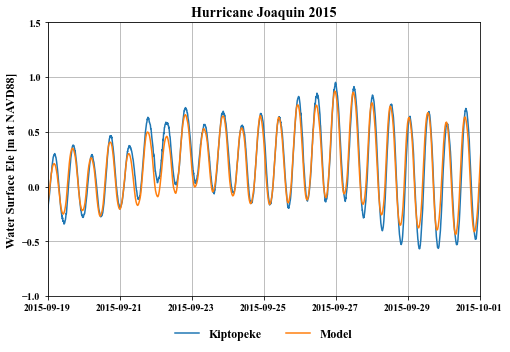

In [6]:
# initialize figure
fig = plt.figure(figsize=(6,4))
ax = plt.axes([0,0,1,.95])
plt.rcParams["font.family"] = "Times New Roman"

# plot data
nc_file = nc4.Dataset(root  / 'implicit015' / 'fort.63.nc')
ax.plot(pd.to_datetime([noaa['data'][i]['t'] for i in range(len(noaa['data']))]),
        [float(noaa['data'][i]['v']) for i in range(len(noaa['data']))],label=noaa['metadata']['name'])

node = ut.find_node_ak(nc_file,float(noaa['metadata']['lat']),float(noaa['metadata']['lon']))
ax.plot(pd.date_range(start=start,periods=int(len(nc_file.variables['zeta'][:,node])),freq=freq),
        nc_file.variables['zeta'][:,node],label='Model')

# annotate figure
ax.set_title('Hurricane Joaquin 2015',fontsize=14),ax.set_ylabel(r'Water Surface Ele [m at NAVD88]',fontsize=12)
ax.set_ylim([-1,1.5])
ax.set_xlim([pd.to_datetime('2015-09-19'),pd.to_datetime('2015-10-01')])

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),ncol=2,frameon=False,fontsize=12)
ax.grid(True)
#plt.savefig('tide_station.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Observation Wave Data

In [7]:
# this finds the observation data and dumps the data in a dataframe
paths = list(pl.Path(r'D:\FHRL_work\Projects\eeslr\field\joaquin2').glob('*'))
obs = {}

for path in paths:
    file = loadmat(path)
    keys = file.keys()
    for key in keys:
        obs.update({path.name:{'Datetime':None,
                               'Hm0':[],
                               'depth':[]}})
        if 'timedepth' in key: 
               obs[path.name]['Datetime'] = pd.Series(pd.to_datetime(file[key][0]-719529, unit='D')+pd.Timedelta(hours=6))
        #elif 'H0' in key:
        #   print(key)
        obs[path.name]['Hm0'] = file['H0'][0]
        #elif 'Depth' in key:
        obs[path.name]['depth'] = file['Depth'][0]

### Calculate distance and nearest nodes

In [8]:
# station distances along polyline "manual measurement"
obs_dist = {'es':[103.652,128.5,156.5,238],
           'mgb':[114.326,129.846,191.494,445.505],
           'di' :[]}

# reads in the polyline shapefiles, then finds the closest nodes, and the distance from the first node.

files = list(pl.Path(r'D:\FHRL_work\Projects\eeslr\locations').glob('*.shp'))

nodes = {'es':[],'mgb':[],'di':[]}
dist = {'es':[],'mgb':[],'di':[]}

keys = list(nodes.keys())
for file in files:
    if file.name.split('_')[0] in keys:
        key = [i for i in keys if file.name.split('_')[0] in i][0]
        i = 0
        for geo in gpd.read_file(file).geometry:
            nodes[key].append(ut.find_node_ak(nc_file,geo.y,geo.x))
            if i < 1:
                o_x,o_y = geo.x,geo.y
            i+=1
            dist[key].append(ut.calc_distance(o_y,o_x,geo.y,geo.x)*1000)

### Plot Station 1 wave height vs model

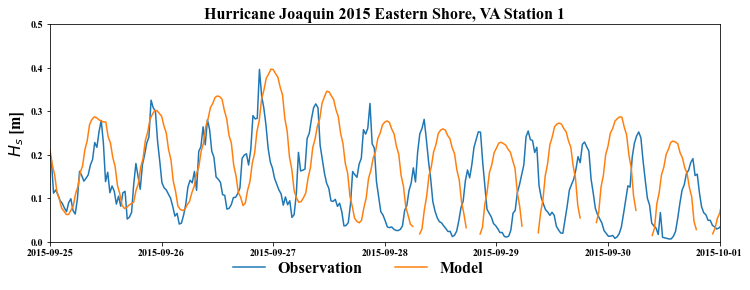

In [92]:
fig,ax = plt.subplots(figsize=(12,4))

nc_file = nc4.Dataset(root  / 'implicit015' / 'swan_HS.63.nc')
ax.plot(obs['sensor_s1_30min_reprocessed.mat']['Datetime'],obs['sensor_s1_30min_reprocessed.mat']['Hm0'],label='Observation')

ax.plot(pd.date_range(start=start,periods=int(len(nc_file.variables['swan_HS'][:,nodes['es'][0]])),freq='30min'),
       nc_file.variables['swan_HS'][:,nodes['es'][0]],label='Model')

# plot annotations
ax.set_xlim([pd.to_datetime('2015-09-25'),pd.to_datetime('2015-10-01')])
ax.set_ylim([0,0.5])
ax.legend(loc='lower center', bbox_to_anchor=(0.46, -0.225),ncol=6,frameon=False,fontsize=16)
ax.set_ylabel(r'$H_{s}$ [m]',fontsize=16)
ax.set_title('Hurricane Joaquin 2015 Eastern Shore, VA Station 1',fontsize=16)

#plt.savefig('es_s1_validation.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Plot station 1 Water Surface Ele vs Model

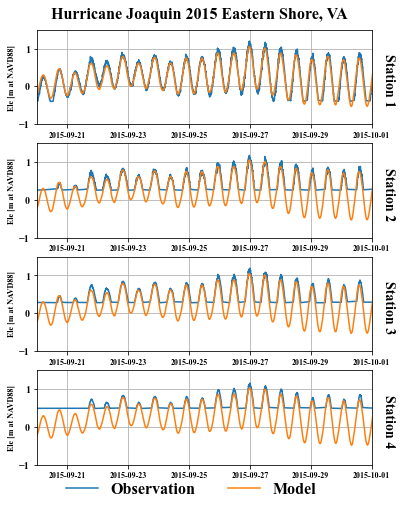

In [55]:
fig,axs = plt.subplots(4,1,figsize=(6,8)) 
paths = pl.Path(r'D:\FHRL_work\Projects\eeslr\field\joaquin')
file = nc4.Dataset(paths / 'es_joaquin.nc','r')
tkeys = ['time_s1', 'time_s2', 'time_s3', 'time_s4']
skeys = ['S1', 'S2', 'S3', 'S4']
node_id = [3,5,7,10]
nc_file = nc4.Dataset(root  / 'implicit015' / 'fort.63.nc')

for i in [0,1,2,3]:
    wl_dt = pd.Series(pd.to_datetime(file.variables[tkeys[i]][:]-719529, unit='D'))+pd.Timedelta(hours=4)
    axs[i].plot(wl_dt,file.variables[skeys[i]][:],label='Observation')   
    axs[i].plot(pd.date_range(start=start,
                              periods=int(len(nc_file.variables['zeta'][:,nodes['es'][node_id[i]]])),
                              freq=freq),
           nc_file.variables['zeta'][:,nodes['es'][node_id[i]]],label='Model')
    axs[i].set_title('Station '+str(i+1),fontsize=14,x=1.05,y=0.15,rotation=-90)
    # plot annotations
    axs[i].set_xlim([pd.to_datetime('2015-09-20'),pd.to_datetime('2015-10-01')])
    axs[i].set_ylim([-1,1.5])
    axs[i].set_ylabel(r'Ele [m at NAVD88]',fontsize=8)
    axs[i].tick_params(axis='x', labelsize=8)
    #axs[i].yaxis.tick_right([])
    #axs[i].yaxis.set_label_position("right")
    #axs[i].set_ylabel('Station '+str(i+1),fontsize=8)
    axs[i].grid(True)

    
fig.suptitle('Hurricane Joaquin 2015 Eastern Shore, VA',fontsize=16,x=0.5,y=0.92)
axs[3].legend(loc='lower center', bbox_to_anchor=(0.46, -0.5),ncol=6,frameon=False,fontsize=16)

plt.savefig('wl_stations_expcd3.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

In [85]:
# here is where it should be modified
start1 = '2015-09-26 22:01:00'
end1 = '2015-09-26 22:31:00'

start2 = '2015-09-26 20:20:00'
end2 = '2015-09-26 20:45:00'

#----------------------------------------------------------------------------------------------
#s1 = '2015-09-15 00:30:00'
names = {'implicit015':'De-coupled Implicit 0.15'}#,'explicit_cd3':r'Explicit $C_{D}$=3'}#'implicit0045':'Implicit 0.045',
new = {}#'..\\Joaquim2\\implicit0045':'De-coupled Implicit 0.045','..\\Joaquim2\\implicit015':'De-coupled Implicit 0.15',
#       '..\\Joaquim2\\implicit0080':'De-coupled Implicit 0.08',
#       'implicit0045':'Coupled Implicit 0.045','explicit_cd3':r'Explicit $C_{D}$=3',
#       'explicit_cd2':r'Explicit $C_{D}$=2','explicit_cd1':r'Explicit $C_{D}$=1'}
colors = ['#009933','#0099ff','#ff00ff','#cc3300']
c2 = ['#336699','#ff0000','#ff9900','#990099','#99cc00','#ff66ff','#ccff66']

ncfile = nc4.Dataset(root / 'implicit015' / 'swan_HS.63.nc')
time = pd.DataFrame()
time['time'] = pd.date_range(start=start,periods=int(len(ncfile.variables['swan_HS'])),freq=freq)
model1 = time.loc[(start1<=time['time'])&(time['time']<end1)].index.values

#nc_file = nc4.Dataset(root / 'implicit0045' / 'swan_HS.63.nc')
#time = pd.DataFrame()
#time['time'] = pd.date_range(start=start,periods=int(len(nc_file.variables['swan_HS'])),freq=freq)
#model2 = time.loc[(start1<=time['time'])&(time['time']<end1)].index.values
obs_keys = list(obs.keys())
k = [0,1,2,3]
ind = obs['sensor_s1_30min_reprocessed.mat']['Datetime'][(start2<=obs['sensor_s1_30min_reprocessed.mat']['Datetime'])&
                                                         (end2>obs['sensor_s1_30min_reprocessed.mat']['Datetime'])].index.values.tolist()[0]
di_t = 297
fort14 = adc.adcirc(root / 'implicit015','fort.14').read_fort14()

In [36]:
np.where(obs['sensor_t2s11_reprocessed.mat']['Hm0']==np.max(obs['sensor_t2s11_reprocessed.mat']['Hm0']))

(array([96], dtype=int64),)

In [37]:
obs['sensor_t2s11_reprocessed.mat']['Datetime'][96]

Timestamp('2017-09-19 14:09:59.829724800')

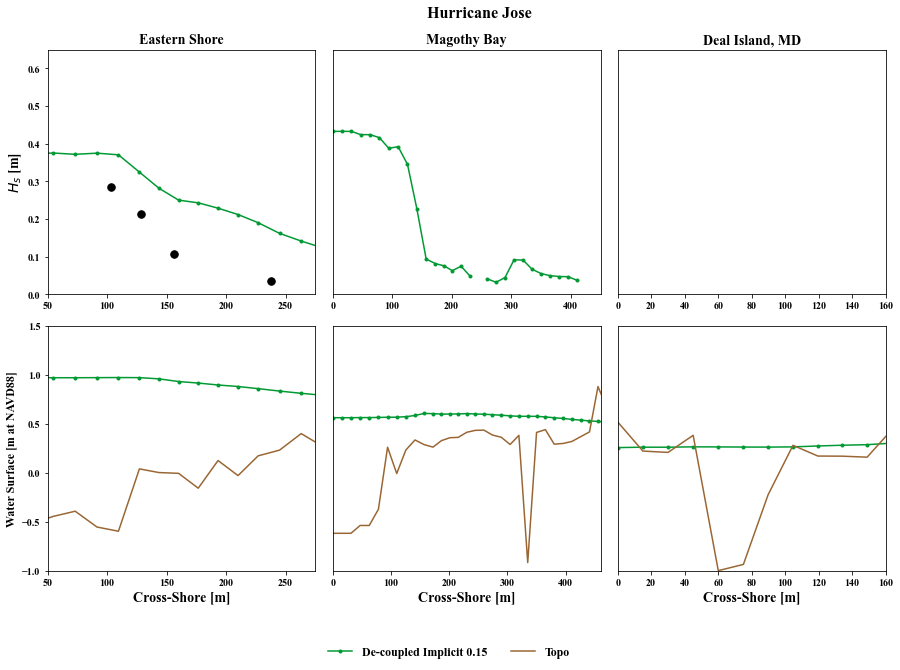

In [86]:
# plot data
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(12,8))
ax1 = plt.axes([0,0.48,0.31,.425])
ax2 = plt.axes([0.33,0.48,0.31,.425])
ax3 = plt.axes([0.66,0.48,0.31,0.425])

ax4 = plt.axes([0,0,0.31,0.4250])
ax5 = plt.axes([0.33,0,0.31,.425])
ax6 = plt.axes([0.66,0,0.31,0.425])


# ---------------------------- wave plots ---------------------------------------------
keys = list(names.keys())
for i in range(len(keys)):
    ncfile = nc4.Dataset(root / keys[i] / 'swan_HS.63.nc')
    ax1.plot(dist['es'],ncfile.variables['swan_HS'][model1,nodes['es']].reshape(len(dist['es'])),'.-',color=colors[i],label=names[keys[i]])
    ax2.plot(dist['mgb'],ncfile.variables['swan_HS'][model1,nodes['mgb']].reshape(len(dist['mgb'],)),'.-',color=colors[i])
    #ax3.plot(dist['di'],ncfile.variables['swan_HS'][di_t,nodes['di']].reshape(len(dist['di'],)),'.-',color=colors[i])

keys = list(new.keys())

# add observation data to plot
data2 = [obs[obs_keys[c]]['Hm0'][ind] for c in k]# if 't2' in obs_keys[c]]
ax1.plot(obs_dist['es'],data2,'.',color='black',linewidth=2,markersize=15,label='Observations')    

# ----------------- water level subplots ----------------------------------------------

keys = list(names.keys())
for i in range(len(keys)):
    ncfile = nc4.Dataset(root / keys[i] / 'fort.63.nc')
    ax4.plot(dist['es'],ncfile.variables['zeta'][model1,nodes['es']].reshape(len(dist['es'])),'.-',color=colors[i],label=names[keys[i]])
    ax5.plot(dist['mgb'],ncfile.variables['zeta'][model1,nodes['mgb']].reshape(len(dist['mgb'],)),'.-',color=colors[i])
    ax6.plot(dist['di'],ncfile.variables['zeta'][di_t,nodes['di']].reshape(len(dist['di'],)),'.-',color=colors[i])


ax4.plot(dist['es'],fort14['value'][np.array(nodes['es'])-1].values.astype(float)*-1,color='#996633',label='Topo')
ax5.plot(dist['mgb'],fort14['value'][np.array(nodes['mgb'])-1].values.astype(float)*-1,color='#996633',label='Topo')
ax6.plot(dist['di'],fort14['value'][np.array(nodes['di'])-1].values.astype(float)*-1,color='#996633',label='Topo')

# annotations for plots 
ax1.set_title('Eastern Shore',fontsize=14),ax1.set_ylabel(r'$H_{s}$ [m]',fontsize=14)
#ax1.set_xlabel('Cross-Shore [m]',fontsize=14),
ax1.set_ylim([0,0.65]),ax1.set_xlim([50,275])
ax4.legend(loc='lower center', bbox_to_anchor=(1.5, -.4),ncol=6,frameon=False,fontsize=12)

ax2.set_title('Magothy Bay',fontsize=14)#,ax2.set_xlabel('Cross-Shore [m]',fontsize=14)
ax2.set_ylim([0,0.65]),ax2.set_xlim([0,450]),ax2.set_yticks([])

ax3.set_title('Deal Island, MD',fontsize=14)#,ax3.set_xlabel('Cross-Shore [m]',fontsize=14)
ax3.set_ylim([0,0.65]),ax3.set_xlim([0,160]),ax3.set_yticks([])



#ax1.set_title('Eastern Shore',fontsize=14),
ax4.set_xlabel('Cross-Shore [m]',fontsize=14)
ax4.set_ylim([-1,1.5]),ax4.set_xlim([50,275])
ax4.set_ylabel(r'Water Surface [m at NAVD88]',fontsize=12)
#ax1.legend(loc='lower center', bbox_to_anchor=(1.5, -0.4),ncol=6,frameon=False,fontsize=12)

#ax2.set_title('Magothy Bay',fontsize=14),
ax5.set_xlabel('Cross-Shore [m]',fontsize=14)
ax5.set_ylim([-1,1.5]),ax5.set_xlim([0,460]),ax5.set_yticks([])

#ax3.set_title('Deal Island, MD',fontsize=14),
ax6.set_xlabel('Cross-Shore [m]',fontsize=14)
ax6.set_ylim([-1,1.5]),ax6.set_xlim([0,160]),ax6.set_yticks([])


fig.suptitle('Hurricane Jose',fontsize=16)
#plt.savefig('comparison.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
#plt.close()
plt.show()

In [85]:
# here is where it should be modified
start1 = '2015-09-26 22:01:00'
end1 = '2015-09-26 22:31:00'

start2 = '2015-09-26 20:20:00'
end2 = '2015-09-26 20:45:00'

#----------------------------------------------------------------------------------------------
#s1 = '2015-09-15 00:30:00'
names = {'implicit015':'De-coupled Implicit 0.15'}#,'explicit_cd3':r'Explicit $C_{D}$=3'}#'implicit0045':'Implicit 0.045',
new = {}#'..\\Joaquim2\\implicit0045':'De-coupled Implicit 0.045','..\\Joaquim2\\implicit015':'De-coupled Implicit 0.15',
#       '..\\Joaquim2\\implicit0080':'De-coupled Implicit 0.08',
#       'implicit0045':'Coupled Implicit 0.045','explicit_cd3':r'Explicit $C_{D}$=3',
#       'explicit_cd2':r'Explicit $C_{D}$=2','explicit_cd1':r'Explicit $C_{D}$=1'}
colors = ['#009933','#0099ff','#ff00ff','#cc3300']
c2 = ['#336699','#ff0000','#ff9900','#990099','#99cc00','#ff66ff','#ccff66']

ncfile = nc4.Dataset(root / 'implicit015' / 'swan_HS.63.nc')
time = pd.DataFrame()
time['time'] = pd.date_range(start=start,periods=int(len(ncfile.variables['swan_HS'])),freq=freq)
model1 = time.loc[(start1<=time['time'])&(time['time']<end1)].index.values

#nc_file = nc4.Dataset(root / 'implicit0045' / 'swan_HS.63.nc')
#time = pd.DataFrame()
#time['time'] = pd.date_range(start=start,periods=int(len(nc_file.variables['swan_HS'])),freq=freq)
#model2 = time.loc[(start1<=time['time'])&(time['time']<end1)].index.values
obs_keys = list(obs.keys())
k = [0,1,2,3]
ind = obs['sensor_s1_30min_reprocessed.mat']['Datetime'][(start2<=obs['sensor_s1_30min_reprocessed.mat']['Datetime'])&
                                                         (end2>obs['sensor_s1_30min_reprocessed.mat']['Datetime'])].index.values.tolist()[0]
di_t = 297
fort14 = adc.adcirc(root / 'implicit015','fort.14').read_fort14()

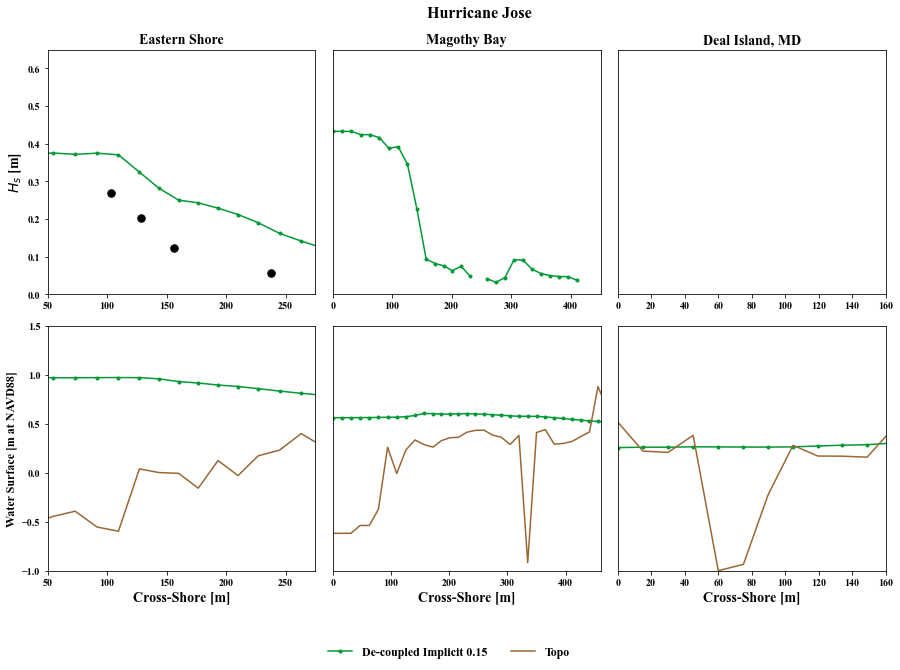

In [73]:
# plot data
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(12,8))
ax1 = plt.axes([0,0.48,0.31,.425])
ax2 = plt.axes([0.33,0.48,0.31,.425])
ax3 = plt.axes([0.66,0.48,0.31,0.425])

ax4 = plt.axes([0,0,0.31,0.4250])
ax5 = plt.axes([0.33,0,0.31,.425])
ax6 = plt.axes([0.66,0,0.31,0.425])


# ---------------------------- wave plots ---------------------------------------------
keys = list(names.keys())
for i in range(len(keys)):
    ncfile = nc4.Dataset(root / keys[i] / 'swan_HS.63.nc')
    ax1.plot(dist['es'],ncfile.variables['swan_HS'][model1,nodes['es']].reshape(len(dist['es'])),'.-',color=colors[i],label=names[keys[i]])
    ax2.plot(dist['mgb'],ncfile.variables['swan_HS'][model1,nodes['mgb']].reshape(len(dist['mgb'],)),'.-',color=colors[i])
    #ax3.plot(dist['di'],ncfile.variables['swan_HS'][di_t,nodes['di']].reshape(len(dist['di'],)),'.-',color=colors[i])

keys = list(new.keys())
# add the vegetation runs    
#for i in range(len(new)):
#    nc_file = nc4.Dataset(root / keys[i] / 'swan_HS.63.nc')
#    ax1.plot(dist['es'],nc_file.variables['swan_HS'][model2,nodes['es']].reshape(len(dist['es'])),'.-',color=c2[i],label=new[keys[i]])
#    ax2.plot(dist['mgb'],nc_file.variables['swan_HS'][model2,nodes['mgb']].reshape(len(dist['mgb'],)),'.-',color=c2[i],label=new[keys[i]])
#    ax3.plot(dist['di'],nc_file.variables['swan_HS'][di_t,nodes['di']].reshape(len(dist['di'],)),'.-',color=c2[i],label=new[keys[i]])

# add observation data to plot
data2 = [obs[obs_keys[c]]['Hm0'][ind] for c in k]# if 't2' in obs_keys[c]]
ax1.plot(obs_dist['es'],data2,'.',color='black',linewidth=2,markersize=15,label='Observations')    

# ----------------- water level subplots ----------------------------------------------

keys = list(names.keys())
for i in range(len(keys)):
    ncfile = nc4.Dataset(root / keys[i] / 'fort.63.nc')
    ax4.plot(dist['es'],ncfile.variables['zeta'][model1,nodes['es']].reshape(len(dist['es'])),'.-',color=colors[i],label=names[keys[i]])
    ax5.plot(dist['mgb'],ncfile.variables['zeta'][model1,nodes['mgb']].reshape(len(dist['mgb'],)),'.-',color=colors[i])
    ax6.plot(dist['di'],ncfile.variables['zeta'][di_t,nodes['di']].reshape(len(dist['di'],)),'.-',color=colors[i])

#keys = list(new.keys())
# add the vegetation runs    
#for i in range(len(new)):
#    nc_file = nc4.Dataset(root / keys[i] / 'fort.63.nc')
#    ax4.plot(dist['es'],nc_file.variables['zeta'][model2,nodes['es']].reshape(len(dist['es'])),'.-',color=c2[i],label=new[keys[i]])
#    ax5.plot(dist['mgb'],nc_file.variables['zeta'][model2,nodes['mgb']].reshape(len(dist['mgb'],)),'.-',color=c2[i],label=new[keys[i]])
#    ax6.plot(dist['di'],nc_file.variables['zeta'][di_t,nodes['di']].reshape(len(dist['di'],)),'.-',color=c2[i],label=new[keys[i]])

tkeys = ['time_s1', 'time_s2', 'time_s3', 'time_s4']
skeys = ['S1', 'S2', 'S3', 'S4']
data = []
#for ii in range(len(skeys)):
    #paths = pl.Path(r'D:\FHRL_work\Projects\eeslr\field\joaquin')
    #file = nc4.Dataset(paths / 'es_joaquin.nc','r')
    #wl_dt = pd.Series(pd.to_datetime(file.variables[tkeys[ii]][:]-719529, unit='D'))+pd.Timedelta(hours=4)
    #wl_ind = wl_dt[(start2<=wl_dt)&(wl_dt<end2)].index.values
    #data.append(np.mean(file.variables[skeys[ii]][wl_ind].data.tolist()))
    #data.append(file.variables[skeys[ii]][wl_ind].data.tolist())
#ax4.plot(obs_dist['es'],data,'.',color='black',linewidth=2,markersize=15,label='Observations')   
ax4.plot(dist['es'],fort14['value'][np.array(nodes['es'])-1].values.astype(float)*-1,color='#996633',label='Topo')


tkeys = ['time_s1', 'time_s3', 'time_s4', 'time_s5']
skeys = ['S1', 'S3', 'S4', 'S5']
data = []
#for ii in range(len(skeys)):
    #paths = pl.Path(r'D:\FHRL_work\Projects\eeslr\field\joaquin')
    #file = nc4.Dataset(paths / 'mgb_joaquin.nc','r')
    #wl_dt = pd.Series(pd.to_datetime(file.variables[tkeys[ii]][:]-719529, unit='D'))+pd.Timedelta(hours=4)
    #wl_ind = wl_dt[(start2<=wl_dt)&(wl_dt<end2)].index.values
    #data.append(np.mean(file.variables[skeys[ii]][wl_ind].data.tolist()))
    #data.append(file.variables[skeys[ii]][wl_ind].data.tolist())
#ax5.plot(obs_dist['mgb'],data,'.',color='black',linewidth=2,markersize=15,label='Observations')   
ax5.plot(dist['mgb'],fort14['value'][np.array(nodes['mgb'])-1].values.astype(float)*-1,color='#996633',label='Topo')



ax6.plot(dist['di'],fort14['value'][np.array(nodes['di'])-1].values.astype(float)*-1,color='#996633',label='Topo')


# annotations for plots 
ax1.set_title('Eastern Shore',fontsize=14),ax1.set_ylabel(r'$H_{s}$ [m]',fontsize=14)
#ax1.set_xlabel('Cross-Shore [m]',fontsize=14),
ax1.set_ylim([0,0.65]),ax1.set_xlim([50,275])
ax4.legend(loc='lower center', bbox_to_anchor=(1.5, -.4),ncol=6,frameon=False,fontsize=12)

ax2.set_title('Magothy Bay',fontsize=14)#,ax2.set_xlabel('Cross-Shore [m]',fontsize=14)
ax2.set_ylim([0,0.65]),ax2.set_xlim([0,450]),ax2.set_yticks([])

ax3.set_title('Deal Island, MD',fontsize=14)#,ax3.set_xlabel('Cross-Shore [m]',fontsize=14)
ax3.set_ylim([0,0.65]),ax3.set_xlim([0,160]),ax3.set_yticks([])



#ax1.set_title('Eastern Shore',fontsize=14),
ax4.set_xlabel('Cross-Shore [m]',fontsize=14)
ax4.set_ylim([-1,1.5]),ax4.set_xlim([50,275])
ax4.set_ylabel(r'Water Surface [m at NAVD88]',fontsize=12)
#ax1.legend(loc='lower center', bbox_to_anchor=(1.5, -0.4),ncol=6,frameon=False,fontsize=12)

#ax2.set_title('Magothy Bay',fontsize=14),
ax5.set_xlabel('Cross-Shore [m]',fontsize=14)
ax5.set_ylim([-1,1.5]),ax5.set_xlim([0,460]),ax5.set_yticks([])

#ax3.set_title('Deal Island, MD',fontsize=14),
ax6.set_xlabel('Cross-Shore [m]',fontsize=14)
ax6.set_ylim([-1,1.5]),ax6.set_xlim([0,160]),ax6.set_yticks([])


fig.suptitle('Hurricane Jose',fontsize=16)
#plt.savefig('comparison.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
#plt.close()
plt.show()

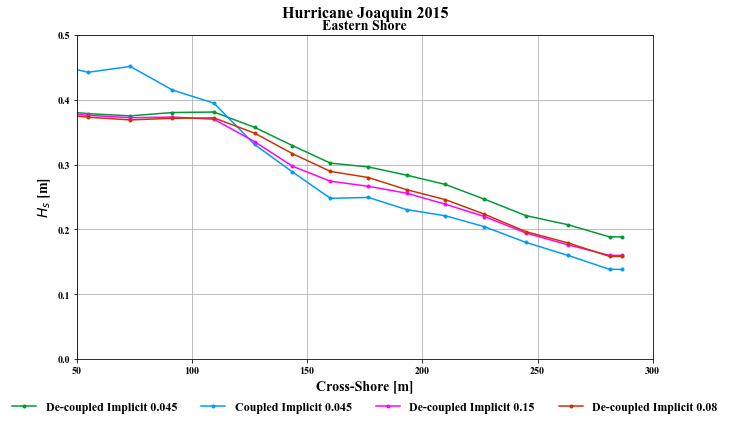

In [40]:
fig = plt.figure(figsize=(8,5))
ax1 = plt.axes([0,0,1,.9])

new = {'..\\Joaquim2\\implicit0045':'De-coupled Implicit 0.045','implicit0045':r'Coupled Implicit 0.045',
      '..\\Joaquim2\\implicit015':'De-coupled Implicit 0.15','..\\Joaquim2\\implicit0080':'De-coupled Implicit 0.08'}


keys = list(new.keys())
# add the vegetation runs    
for i in range(len(new)):
    ncfile = nc4.Dataset(root / keys[i] / 'swan_HS.63.nc')
    ax1.plot(dist['es'],ncfile.variables['swan_HS'][model2,nodes['es']].reshape(len(dist['es'])),'.-',color=colors[i],label=new[keys[i]])
    
ax1.set_title('Eastern Shore',fontsize=14),ax1.set_ylabel(r'$H_{s}$ [m]',fontsize=14)
#ax1.set_xlabel('Cross-Shore [m]',fontsize=14),
ax1.set_ylim([0,0.5]),ax1.set_xlim([50,300])
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),ncol=6,frameon=False,fontsize=12)
ax1.set_xlabel('Cross-Shore [m]',fontsize=14)
fig.suptitle('Hurricane Joaquin 2015',fontsize=16)
ax1.grid(True)
#plt.savefig('comparison.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
#plt.close()
plt.show()

In [36]:
obs_dist['es']

[103.652, 128.5, 156.5, 238]

In [228]:
temp = np.where(nc_file.variables['zeta'][:,nodes['es'][2]]==np.max(nc_file.variables['zeta'][:,nodes['es'][2]]))
pd.date_range(start=start,periods=int(len(nc_file.variables['zeta'][:])),freq=freq)[temp]

DatetimeIndex(['2015-09-27 12:00:00'], dtype='datetime64[ns]', freq=None)

In [28]:
# plot data

start1 = '2015-09-27 01:01:00'
end1 = '2015-09-27 01:31:00'

start2 = '2015-09-27 01:28:00'
end2 = '2015-09-27 01:36:00'

ncfile = nc4.Dataset(root / 'implicit015' / 'fort.63.nc')
time = pd.DataFrame()
time['time'] = pd.date_range(start=s1,periods=int(len(ncfile.variables['zeta'])),freq=freq)
model1 = time.loc[(start1<=time['time'])&(time['time']<end1)].index.values

nc_file = nc4.Dataset(root / 'implicit0045' / 'fort.63.nc')
time = pd.DataFrame()
time['time'] = pd.date_range(start=start,periods=int(len(nc_file.variables['zeta'])),freq=freq)
model2 = time.loc[(start1<=time['time'])&(time['time']<end1)].index.values

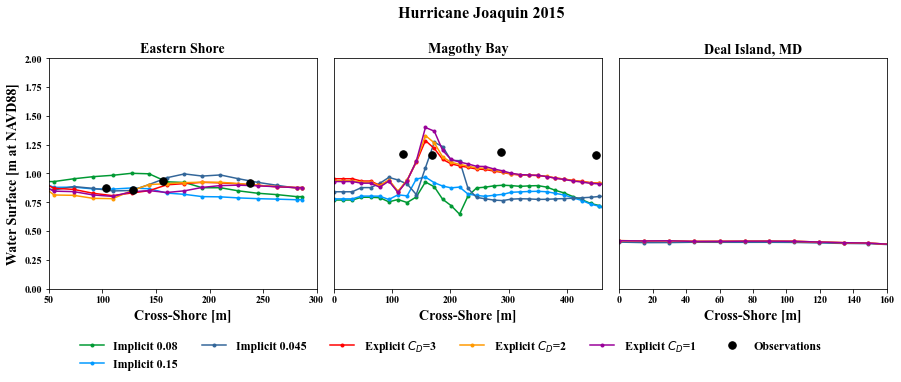

In [29]:
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(12,4))
ax1 = plt.axes([0,0,0.31,.80])
ax2 = plt.axes([0.33,0,0.31,.8])
ax3 = plt.axes([0.66,0,0.31,0.8])

keys = list(names.keys())
for i in [0,1]:
    ncfile = nc4.Dataset(root / keys[i] / 'fort.63.nc')
    ax1.plot(dist['es'],ncfile.variables['zeta'][model1,nodes['es']].reshape(len(dist['es'])),'.-',color=colors[i],label=names[keys[i]])
    ax2.plot(dist['mgb'],ncfile.variables['zeta'][model1,nodes['mgb']].reshape(len(dist['mgb'],)),'.-',color=colors[i])
    ax3.plot(dist['di'],ncfile.variables['zeta'][di_t,nodes['di']].reshape(len(dist['di'],)),'.-',color=colors[i])

keys = list(new.keys())
# add the vegetation runs    
for i in range(len(new)):
    nc_file = nc4.Dataset(root / keys[i] / 'fort.63.nc')
    ax1.plot(dist['es'],nc_file.variables['zeta'][model2,nodes['es']].reshape(len(dist['es'])),'.-',color=c2[i],label=new[keys[i]])
    ax2.plot(dist['mgb'],nc_file.variables['zeta'][model2,nodes['mgb']].reshape(len(dist['mgb'],)),'.-',color=c2[i],label=new[keys[i]])
    ax3.plot(dist['di'],nc_file.variables['zeta'][di_t,nodes['di']].reshape(len(dist['di'],)),'.-',color=c2[i],label=new[keys[i]])

tkeys = ['time_s1', 'time_s2', 'time_s3', 'time_s4']
skeys = ['S1', 'S2', 'S3', 'S4']
data = []
for ii in range(len(skeys)):
    paths = pl.Path(r'D:\FHRL_work\Projects\eeslr\field\joaquin')
    file = nc4.Dataset(paths / 'es_joaquin.nc','r')
    wl_dt = pd.Series(pd.to_datetime(file.variables[tkeys[ii]][:]-719529, unit='D'))+pd.Timedelta(hours=4)
    wl_ind = wl_dt[(start2<=wl_dt)&(wl_dt<end2)].index.values
    data.append(np.mean(file.variables[skeys[ii]][wl_ind].data.tolist()))
ax1.plot(obs_dist['es'],data,'.',color='black',linewidth=2,markersize=15,label='Observations')   

tkeys = ['time_s1', 'time_s3', 'time_s4', 'time_s5']
skeys = ['S1', 'S3', 'S4', 'S5']
data = []
for ii in range(len(skeys)):
    paths = pl.Path(r'D:\FHRL_work\Projects\eeslr\field\joaquin')
    file = nc4.Dataset(paths / 'mgb_joaquin.nc','r')
    wl_dt = pd.Series(pd.to_datetime(file.variables[tkeys[ii]][:]-719529, unit='D'))+pd.Timedelta(hours=4)
    wl_ind = wl_dt[(start2<=wl_dt)&(wl_dt<end2)].index.values
    data.append(np.mean(file.variables[skeys[ii]][wl_ind].data.tolist()))
ax2.plot(obs_dist['mgb'],data,'.',color='black',linewidth=2,markersize=15,label='Observations')   

# annotations for plots 
ax1.set_title('Eastern Shore',fontsize=14),ax1.set_xlabel('Cross-Shore [m]',fontsize=14)
ax1.set_ylim([0,2]),ax1.set_xlim([50,300])
ax1.set_ylabel(r'Water Surface [m at NAVD88]',fontsize=14)
ax1.legend(loc='lower center', bbox_to_anchor=(1.5, -0.4),ncol=6,frameon=False,fontsize=12)

ax2.set_title('Magothy Bay',fontsize=14),ax2.set_xlabel('Cross-Shore [m]',fontsize=14)
ax2.set_ylim([0,2]),ax2.set_xlim([0,460]),ax2.set_yticks([])

ax3.set_title('Deal Island, MD',fontsize=14),ax3.set_xlabel('Cross-Shore [m]',fontsize=14)
ax3.set_ylim([0,2]),ax3.set_xlim([0,160]),ax3.set_yticks([])

fig.suptitle('Hurricane Joaquin 2015',fontsize=16)
#plt.savefig('comparison.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
#plt.close()
plt.show()

In [305]:
file = nc4.Dataset(paths / 'es_joaquin.nc','r')
temp = np.where(file.variables['S1'][1100:]==np.min(file.variables['S1'][1100:]))
pd.Series(pd.to_datetime(file.variables['time_s1'][temp]-719529, unit='D'))+pd.Timedelta(hours=6),np.max(file.variables['S1'][:10200])

(0    2015-08-14 00:54:00.000000000
 1    2015-08-21 14:24:00.000000000
 2    2015-08-21 14:35:59.999971199
 3    2015-08-22 01:48:00.000000000
 4    2015-08-22 01:54:00.000028800
 5    2015-08-24 13:12:00.000000000
 6    2015-09-03 05:30:00.000028800
 7    2015-09-03 05:48:00.000028800
 8    2015-09-04 07:00:00.000028800
 9    2015-09-04 18:00:00.000000000
 10   2015-09-09 11:53:59.999971200
 11   2015-09-09 12:11:59.999971200
 12   2015-09-09 12:24:00.000028800
 13   2015-09-09 12:42:00.000028800
 14   2015-09-09 12:47:59.999971200
 15   2015-09-12 02:48:00.000028800
 16   2015-10-05 15:29:59.999971200
 dtype: datetime64[ns],
 1.197236)

### Wave Energy Calculation
    
E = kH^2   where k = pg/8

H is the height of a sinosodal wave       
p = 1020 kg per m3 "density of sea water"         
g = 9.81 m per s


In [228]:
from wave_utils import waves

In [236]:
fort14 = adc(root / 'implicit015','fort.14').read_fort14()
#f14 = adc.read_fort14()

In [230]:
wl = 

<function wave_utils.waves.dispersion(p, tol=1e-14, max_iter=100)>

In [303]:
# here is where it should be modified
start1 = '2015-09-27 00:01:00'
end1 = '2015-09-27 00:31:00'

start2 = '2015-09-26 23:00:00'
end2 = '2015-09-26 23:10:00'

#----------------------------------------------------------------------------------------------
s1 = '2015-09-15 00:30:00'
names = {'implicit0080':'Implicit 0.08','implicit015':'Implicit 0.15',}#'implicit0045':'Implicit 0.045',
new = {'..\\Joaquim2\\implicit0045':'De-coupled Implicit 0.045','implicit0045':'Coupled Implicit 0.045',
       'explicit_cd3':r'Explicit $C_{D}$=3',
       'explicit_cd2':r'Explicit $C_{D}$=2','explicit_cd1':r'Explicit $C_{D}$=1'}
colors = ['#009933','#0099ff','#ff00ff','#cc3300']
c2 = ['#336699','#ff0000','#ff9900','#990099','#99cc00']

ncfile = nc4.Dataset(root / 'implicit015' / 'swan_HS.63.nc')
time = pd.DataFrame()
time['time'] = pd.date_range(start=s1,periods=int(len(ncfile.variables['swan_HS'])),freq=freq)
model1 = time.loc[(start1<=time['time'])&(time['time']<end1)].index.values

nc_file = nc4.Dataset(root / 'implicit0045' / 'swan_HS.63.nc')
time = pd.DataFrame()
time['time'] = pd.date_range(start=start,periods=int(len(nc_file.variables['swan_HS'])),freq=freq)
model2 = time.loc[(start1<=time['time'])&(time['time']<end1)].index.values

ind = obs.loc[(start2<=obs['Datetime'])&(end2>obs['Datetime'])].index.values.tolist()[0]
di_t = 297
rho = 1020
tau = 2 * np.pi
g = 9.80665

In [304]:
names

{'implicit0080': 'Implicit 0.08', 'implicit015': 'Implicit 0.15'}

In [ ]:
E = 0.5*rho*g*np.square(A)

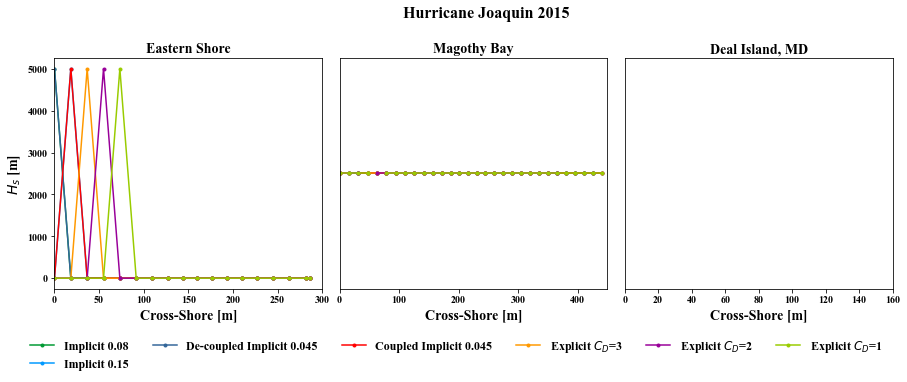

In [317]:
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(12,4))
ax1 = plt.axes([0,0,0.31,.8])
ax2 = plt.axes([0.33,0,0.31,.8])
ax3 = plt.axes([0.66,0,0.31,0.8])




# ---------------------------- wave plots ---------------------------------------------
keys = list(names.keys())
for i in [0,1]:
    
    depth = nc4.Dataset(root / keys[i] / 'fort.63.nc').variables['zeta'][model1,nodes['es']]-\
            fort14['value'][np.array(nodes['es'])-1].values.astype(float)
    T = nc4.Dataset(root / keys[i] / 'swan_TPS.63.nc').variables['swan_TPS'][model1,nodes['es']]
    omega = tau / T
    E = omega[0]*0
    for ii in range(len(omega[0])):
        wl = tau / waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
        k = waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
        #A = 0.5*nc4.Dataset(root / keys[i] / 'swan_HS.63.nc').variables['swan_HS'][model1,nodes['es'][ii]]
        A = np.cosh(k * (depth[0][i])) / np.cosh(k * (depth[0][i]))
        E[i] = 0.5*rho*g*np.square(A)
    
    ax1.plot(dist['es'],E,'.-',color=colors[i],label=names[keys[i]])
    

    depth = nc4.Dataset(root / keys[i] / 'fort.63.nc').variables['zeta'][model1,nodes['mgb']]-\
            fort14['value'][np.array(nodes['mgb'])-1].values.astype(float)
    T = nc4.Dataset(root / keys[i] / 'swan_TPS.63.nc').variables['swan_TPS'][model1,nodes['mgb']]
    omega = tau / T
    E = omega[0]*0
    for ii in range(len(omega[0])):
        wl = tau / waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
        k = waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
        A = 0.5*nc4.Dataset(root / keys[i] / 'swan_HS.63.nc').variables['swan_HS'][model1,nodes['mgb'][ii]] 
        #np.cosh(k * (depth[0][i])) / np.cosh(k * (depth[0][i]))
        E[i] = 0.5*rho*g*np.square(A)      
    ax2.plot(dist['mgb'],E,'.-',color=colors[i])
    
    depth = nc4.Dataset(root / keys[i] / 'fort.63.nc').variables['zeta'][di_t,nodes['di']]-\
            fort14['value'][np.array(nodes['di'])-1].values.astype(float)
    T = nc4.Dataset(root / keys[i] / 'swan_TPS.63.nc').variables['swan_TPS'][di_t,nodes['di']]
    omega = tau / T
    E = omega[0]*0
    try:
        for ii in range(len(nodes['di'])):
            wl = tau / waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
            k = waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
            A = 0.5*nc4.Dataset(root / keys[i] / 'swan_HS.63.nc').variables['swan_HS'][di_t,nodes['di'][ii]] 
            #np.cosh(k * (depth[0][i])) / np.cosh(k * (depth[0][i]))
            E[i] = 0.5*rho*g*np.square(A) 
        ax3.plot(dist['di'],E,'.-',color=colors[i])
    except:
        pass

keys = list(new.keys())
# add the vegetation runs    
for i in range(len(new)):
    depth = nc4.Dataset(root / keys[i] / 'fort.63.nc').variables['zeta'][model2,nodes['es']]-\
            fort14['value'][np.array(nodes['es'])-1].values.astype(float)
    T = nc4.Dataset(root / keys[i] / 'swan_TPS.63.nc').variables['swan_TPS'][model2,nodes['es']]
    omega = tau / T
    E = omega[0]*0
    for ii in range(len(omega[0])):
        wl = tau / waves.wave_number(g,omega.data[0][i],depth.data[0][ii])
        k = waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
        #A = #0.5*nc4.Dataset(root / keys[i] / 'swan_HS.63.nc').variables['swan_HS'][model2,nodes['es'][ii]] 
        A = np.cosh(k * (depth[0][i])) / np.cosh(k * (depth[0][i]))
        E[i] = 0.5*rho*g*np.square(A)
    
    ax1.plot(dist['es'],E,'.-',color=c2[i],label=new[keys[i]])
    

    depth = nc4.Dataset(root / keys[i] / 'fort.63.nc').variables['zeta'][model2,nodes['mgb']]-\
            fort14['value'][np.array(nodes['mgb'])-1].values.astype(float)
    T = nc4.Dataset(root / keys[i] / 'swan_TPS.63.nc').variables['swan_TPS'][model2,nodes['mgb']]
    omega = tau / T
    E = omega[0]*0
    for ii in range(len(omega[0])):
        wl = tau / waves.wave_number(g,omega.data[0][i],depth.data[0][ii])
        k = waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
        A = 0.5*nc4.Dataset(root / keys[i] / 'swan_HS.63.nc').variables['swan_HS'][model2,nodes['mgb'][ii]] 
        #np.cosh(k * (depth[0][i])) / np.cosh(k * (depth[0][i]))
        E[i] = 0.5*rho*g*np.square(A)      
    ax2.plot(dist['mgb'],E,'.-',color=c2[i])
    
    depth = nc4.Dataset(root / keys[i] / 'fort.63.nc').variables['zeta'][di_t,nodes['di']]-\
            fort14['value'][np.array(nodes['di'])-1].values.astype(float)
    T = nc4.Dataset(root / keys[i] / 'swan_TPS.63.nc').variables['swan_TPS'][di_t,nodes['di']]
    omega = tau / T
    E = omega[0]*0
    try:
        for ii in range(len(omega[0])):
            wl = tau / waves.wave_number(g,omega.data[0][i],depth.data[0][ii])
            k = waves.wave_number(g,omega.data[0][ii],depth.data[0][ii])
            A = 0.5*nc4.Dataset(root / keys[i] / 'swan_HS.63.nc').variables['swan_HS'][di_t,nodes['di'][ii]] 
            #np.cosh(k * (depth[0][i])) / np.cosh(k * (depth[0][i]))
            E[i] = 0.5*rho*g*np.square(A) 
        ax3.plot(dist['di'],E,'.-',color=c2[i])
    except:
        pass

# add observation data to plot
#data2 = [k*np.square(obs[c].loc[ind]) for c in obs.columns if 'Hm0_' in c]
#ax1.plot(obs_dist['es'],data2,'.',color='black',linewidth=2,markersize=15,label='Observations')    




ax1.set_title('Eastern Shore',fontsize=14),ax1.set_ylabel(r'$H_{s}$ [m]',fontsize=14)
ax1.set_xlabel('Cross-Shore [m]',fontsize=14),
#ax1.set_ylim([0,10]),
ax1.set_xlim([0,300])
ax1.legend(loc='lower center', bbox_to_anchor=(1.5, -.4),ncol=6,frameon=False,fontsize=12)

ax2.set_title('Magothy Bay',fontsize=14),ax2.set_xlabel('Cross-Shore [m]',fontsize=14)
#ax2.set_ylim([0,0.65]),
ax2.set_xlim([0,450]),ax2.set_yticks([])

ax3.set_title('Deal Island, MD',fontsize=14),ax3.set_xlabel('Cross-Shore [m]',fontsize=14)
#ax3.set_ylim([0,0.65]),
ax3.set_xlim([0,160]),ax3.set_yticks([])
fig.suptitle('Hurricane Joaquin 2015',fontsize=16)
#plt.savefig('comparison.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
#plt.close()
plt.show()

In [312]:
new[keys[i]]

'Explicit $C_{D}$=1'

In [302]:
names

{'implicit0080': 'Implicit 0.08', 'implicit015': 'Implicit 0.15'}